In [1]:
import time

import torch
from matplotlib import pyplot as plt

from pykeops.torch import LazyTensor

In [2]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

N = 10000 if use_cuda else 1000  # Number of samples

# Sampling locations:
x = torch.rand(N, 1).type(dtype)

# Some random-ish 1D signal:
b = x + .5 * (6 * x).sin() + .1 * (20 * x).sin() + .05 * torch.randn(N, 1).type(dtype)

In [3]:
def gaussian_kernel(x, y, sigma=.1):
    x_i = LazyTensor(x[:, None, :])  # (M, 1, 1)
    y_j = LazyTensor(y[None, :, :])  # (1, N, 1)
    D_ij = ((x_i - y_j) ** 2).sum(-1)  # (M, N) symbolic matrix of squared distances
    return (- D_ij / (2 * sigma ** 2)).exp()  # (M, N) symbolic Gaussian kernel matrix

In [4]:
alpha = 1.  # Ridge regularization

start = time.time()

K_xx = gaussian_kernel(x, x)
a = K_xx.solve(b, alpha=alpha)

end = time.time()

print('Time to perform an RBF interpolation with {:,} samples in 1D: {:.5f}s'.format(
    N, end - start))

Time to perform an RBF interpolation with 10,000 samples in 1D: 0.06929s


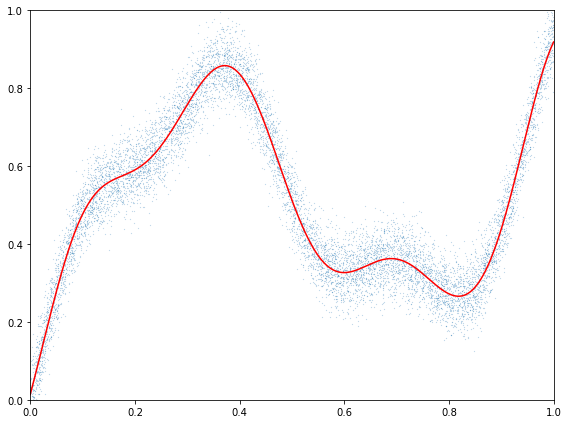

In [5]:
# Extrapolate on a uniform sample:
t = torch.linspace(0, 1, 1001).type(dtype)[:, None]

K_tx = gaussian_kernel(t, x)
mean_t = K_tx @ a

# 1D plot:
plt.figure(figsize=(8, 6))

plt.scatter(x.cpu()[:, 0], b.cpu()[:, 0], s=100 / len(x))  # Noisy samples
plt.plot(t.cpu().numpy(), mean_t.cpu().numpy(), "r")

plt.axis([0, 1, 0, 1]);
plt.tight_layout()

In [6]:
# Sampling locations:
x = torch.rand(N, 3).type(dtype)

# Some random-ish 2D signal:
b = ((x - .5) ** 2).sum(1, keepdim=True)
b[b > .4 ** 2] = 0
b[b < .3 ** 2] = 0
b[b >= .3 ** 2] = 1
b = b + .05 * torch.randn(N, 1).type(dtype)

# Add 25% of outliers:
Nout = N // 4
b[-Nout:] = torch.rand(Nout, 1).type(dtype)

In [7]:
b.shape

torch.Size([10000, 1])

In [8]:
def laplacian_kernel(x, y, sigma=.1):
    x_i = LazyTensor(x[:, None, :])  # (M, 1, 1)
    y_j = LazyTensor(y[None, :, :])  # (1, N, 1)
    D_ij = ((x_i - y_j) ** 2).sum(-1)  # (M, N) symbolic matrix of squared distances
    return (- D_ij.sqrt() / sigma).exp()  # (M, N) symbolic Laplacian kernel matrix

In [9]:
alpha = 10  # Ridge regularization

start = time.time()

K_xx = laplacian_kernel(x, x)
a = K_xx.solve(b, alpha=alpha)

end = time.time()

print('Time to perform an RBF interpolation with {:,} samples in 2D: {:.5f}s'.format(N, end - start))

Time to perform an RBF interpolation with 10,000 samples in 2D: 0.03744s


In [10]:
X = Y = Z = torch.linspace(0, 1, 101).type(dtype)

In [11]:
t.shape

torch.Size([1001, 1])

In [12]:
from spimagine import volshow

In [13]:
%gui qt5

In [14]:
x.shape

torch.Size([10000, 3])

In [15]:
# Extrapolate on a uniform sample:
X = Y = Z = torch.linspace(0, 1, 101).type(dtype)
X, Y, Z = torch.meshgrid(X, Y, Z)
t = torch.stack((X.contiguous().view(-1), Y.contiguous().view(-1), Z.contiguous().view(-1)), dim=1)

K_tx = laplacian_kernel(t, x)
mean_t = K_tx @ a
mean_t = mean_t.view(101, 101, 101)


"""
# 2D plot: noisy samples and interpolation in the background
plt.figure(figsize=(8, 8))

plt.scatter(x.cpu()[:, 0], x.cpu()[:, 1], c=b.cpu().view(-1), s=25000 / len(x), cmap="bwr")
plt.imshow(mean_t.cpu().numpy()[::-1, :], interpolation="bilinear", extent=[0, 1, 0, 1], cmap="coolwarm")

# sphinx_gallery_thumbnail_number = 2
plt.axis([0, 1, 0, 1])
plt.tight_layout()
plt.show()
"""


'\n# 2D plot: noisy samples and interpolation in the background\nplt.figure(figsize=(8, 8))\n\nplt.scatter(x.cpu()[:, 0], x.cpu()[:, 1], c=b.cpu().view(-1), s=25000 / len(x), cmap="bwr")\nplt.imshow(mean_t.cpu().numpy()[::-1, :], interpolation="bilinear", extent=[0, 1, 0, 1], cmap="coolwarm")\n\n# sphinx_gallery_thumbnail_number = 2\nplt.axis([0, 1, 0, 1])\nplt.tight_layout()\nplt.show()\n'

In [16]:
volshow(mean_t.cpu().numpy())